# Check the sensitivity of one basin
Using emulator to obtain the sensitivity

In [1]:
# use observed streamflow data to evaluate model outputs
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, sys

def get_modified_KGE(obs,sim):
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge

# Load data

In [2]:
# load data
infile_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(infile_info)

outpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs_evaluation'
outfile = f'{outpath}/obs_streamflow.nc'
ds_q_obs = xr.load_dataset(outfile)

In [3]:
niter = 200
nparam = 27
params = np.nan * np.zeros([niter+1, nparam])

for i in range(-1, niter):
    if i>=0:
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/paramset_iter0_trial{i}.pkl'
    else:
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/all_default_parameters.pkl' # -1: default paramters
        
    df_param = pd.read_pickle(file)
    va = df_param['Value'].values
    for j in range(nparam):
        params[i+1, j]=np.mean(va[j])

In [4]:
ngrid = len(ds_q_obs.lndgrid)
kge = np.nan * np.zeros([niter+1, ngrid])
for t in range(-1, niter): # -1 is default
    # outfile metric
    outfile_metric = f'{outpath}/metric_iter0_trial{t}.csv'
    df_metric = pd.read_csv(outfile_metric)
    kge[t+1, :] = df_metric['KGEmod'].values

In [5]:
print(kge.shape)
print(params.shape)

(201, 627)
(201, 27)


# Select one basin

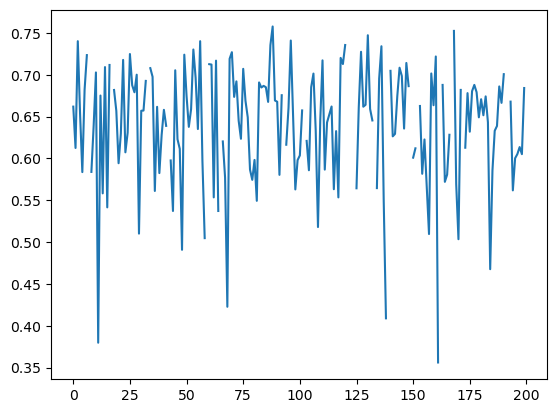

In [6]:
checkbasin = 530
plt.plot(kge[:,checkbasin])

(27,) (180,) (180, 27)


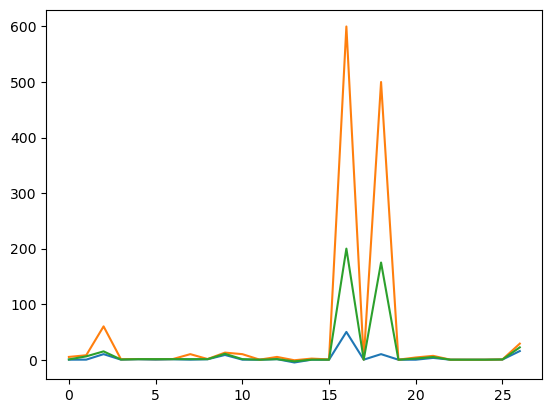

In [7]:
lower = df_param['Lower'].values.copy()[:-3]
upper = df_param['Upper'].values.copy()[:-3]
default = df_param['Default'].values.copy()[:-3]
kgebasin = kge[:, checkbasin].copy()
paramsbasin = params.copy()

indvalid = ~np.isnan(kgebasin)
kgebasin = kgebasin[indvalid]
paramsbasin = paramsbasin[indvalid, :]

print(lower.shape, kgebasin.shape, paramsbasin.shape)
plt.plot(lower)
plt.plot(upper)
plt.plot(default)

# Build an emulator

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


Test MSE: 0.0030078936766963155; CC 0.6386324664394648


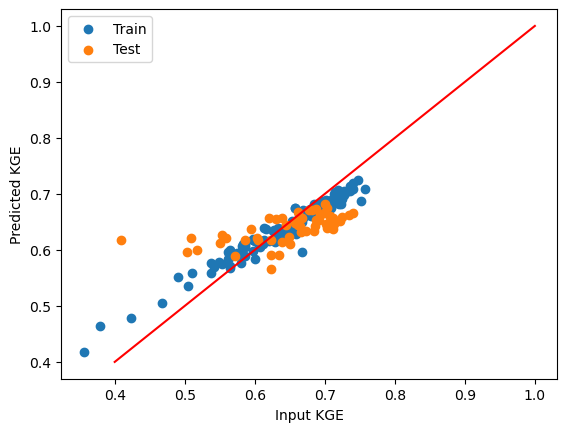

In [9]:
# validation test

# Step 1: Building the emulator
# Split the data into training and testing for model evaluation
X_train, X_test, y_train, y_test = train_test_split(paramsbasin, kgebasin, test_size=0.3, random_state=42)

# Initialize and train the emulator (regression model) using Random Forest
emulator = RandomForestRegressor(n_estimators=100, random_state=42)  # Random Forest model initialization

emulator.fit(X_train, y_train)

# Evaluate the emulator to ensure it's good enough for sensitivity analysis
y_pred = emulator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}; CC {np.corrcoef(y_pred, y_test)[0,1]}")

# plot 
plt.scatter(y_train, emulator.predict(X_train), label='Train')
plt.scatter(y_test, y_pred, label='Test')
plt.plot([0.4, 1], [0.4, 1], 'r')
plt.xlabel('Input KGE')
plt.ylabel('Predicted KGE')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train period using all sample; MSE: 0.0005031022050483037; CC 0.9761919881819218


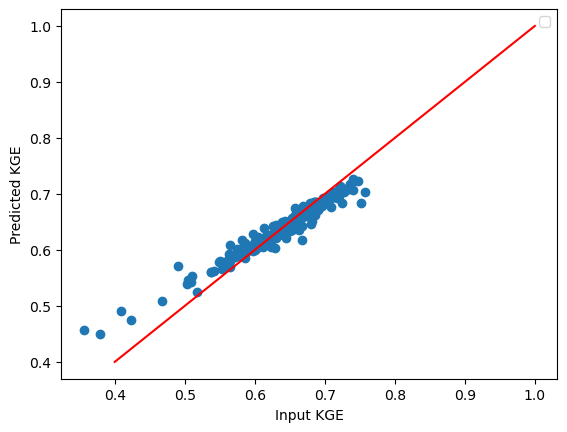

In [10]:
# build another emulator using all samples
emulator = RandomForestRegressor(n_estimators=100, random_state=42)  # Random Forest model initialization
emulator.fit(paramsbasin, kgebasin)

y_pred = emulator.predict(paramsbasin)
mse = mean_squared_error(kgebasin, y_pred)
print(f"Train period using all sample; MSE: {mse}; CC {np.corrcoef(y_pred, kgebasin)[0,1]}")

# plot 
plt.scatter(kgebasin, y_pred)
plt.plot([0.4, 1], [0.4, 1], 'r')
plt.xlabel('Input KGE')
plt.ylabel('Predicted KGE')
plt.legend()
plt.show()

In [11]:
# check emulator on default parameters
kge_pred_default = emulator.predict(default[np.newaxis, :])
print('pred', kge_pred_default, 'default', kgebasin[0])



pred [0.64020772] default 0.6619112609638191


In [12]:
# # one-at-a-time perturbation of default parameters (not good, no change)
# n = 20
# kge_pred_default_oaat = np.nan * np.zeros([len(lower), n])

# paraminput = np.nan * np.zeros([len(lower), len(lower), n])

# for i in range(len(lower)):
#     pi = np.linspace(lower[i], upper[i], n)
#     for j in range(n):
#         pij = default.copy()
#         pij[i] = pi[j]

        
#         kge_pred_default_oaat[i, j] = emulator.predict(pij[np.newaxis, :])[0]

In [13]:
# check one parameter (random samples)
i = 20
print(lower[i])
print(default[i])
print(upper[i])
print(emulator.predict(default[np.newaxis,:]), emulator.predict(lower[np.newaxis,:]), emulator.predict(upper[np.newaxis,:]))

# pp = default.copy()
# pp[i] = lower[i]
pp = np.array([np.random.uniform(lower[i], upper[i], 1)[0] for i in range(len(lower))])
print(emulator.predict(pp[np.newaxis,:]))

0.0
2.0
4.0
[0.64020772] [0.49905693] [0.62054125]
[0.69170093]


In [14]:
# Latin hypercube sampling and sensitivity analysis (Yifan's method)

import numpy as np
from scipy.stats import qmc

n_values = 5
n_samples = 20

n_parameters = len(lower)
sensitivities = np.zeros(n_parameters)

kge_pred_lhs = np.nan * np.zeros([n_parameters, n_samples, n_values])

for i in range(n_parameters):
    values = np.linspace(lower[i], upper[i], n_values)

    for j in range(n_values):
        value = values[j]

        # Generate LHS for the remaining parameters
        sampler = qmc.LatinHypercube(d=n_parameters - 1)
        samples = qmc.scale(sampler.random(n=n_samples), lower[np.arange(len(lower)) != i],
                            upper[np.arange(len(upper)) != i])
    
        for p in range(n_samples):
    
            sample = samples[p]
            # Insert the fixed parameter value into the sampled set
            param_set = np.insert(sample, i, value)
            # Predict kge using the emulator
            predicted_kge = emulator.predict(param_set[np.newaxis, :])
            
            kge_pred_lhs[i, p, j] = predicted_kge[0]

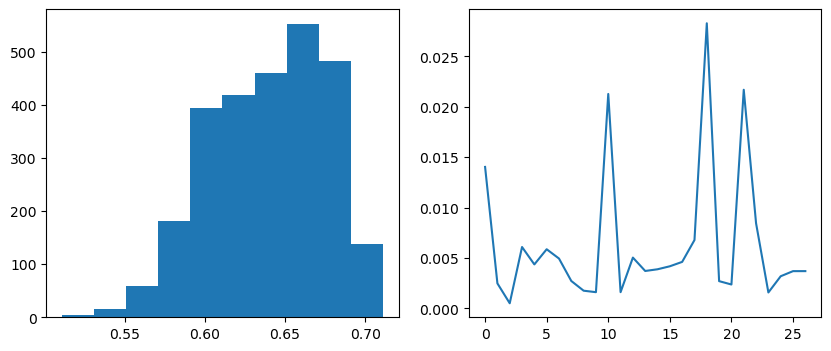

sorted sensitivity: [0.02828477 0.02169205 0.02127497 0.01404014 0.00845286 0.00678876
 0.00609674 0.00587475 0.00504786 0.00495445 0.00462121 0.00437207
 0.00418663 0.00388947 0.00372037 0.00370617 0.00370437 0.00319823
 0.00272799 0.00271247 0.0024907  0.00237906 0.00176515 0.00161844
 0.00161805 0.00158917 0.00051738]
sorted parameter: ['upplim_destruct_metamorph' 'medlynslope' 'hksat_sf' 'fff' 'jmaxb0'
 'accum_factor' 'FMAX' 'interception_fraction' 'n_baseflow' 'watsat_sf'
 'n_melt_coef' 'om_frac_sf' 'maximum_leaf_wetted_fraction'
 'liq_canopy_storage_scalar' 'slopebeta' 'leafcn' 'taulnir' 'cv'
 'sucsat_sf' 'zsno' 'e_ice' 'precip_repartition_nonglc_all_rain_t'
 'bsw_sf' 'zbedrock' 'baseflow_scalar' 'kmax' 'd_max']


In [30]:
# LHS: plot and analyis
kge_pred_lhs_mean = np.std(np.nanmean(kge_pred_lhs, axis=1),axis=1)

fig = plt.figure(figsize=[10, 4])

fig.add_subplot(1,2,1)
plt.hist(kge_pred_lhs.flatten())

fig.add_subplot(1,2,2)
plt.plot(kge_pred_lhs_mean)
plt.show()

# select parameters
senst = kge_pred_lhs_mean
indsort = np.argsort(-senst)
paramnames = df_param['Parameter'].values[:-3]

print('sorted sensitivity:', senst[indsort])
print('sorted parameter:', paramnames[indsort])